# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Performe Tsne Analysis on the various featurization of the text data which representation can better differentiate positive from negative.



import sqlite3

In [11]:
con = sqlite3.connect('./database.sqlite') 

In [12]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer





In [13]:
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 

In [14]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [15]:
#changing the score to +ve or -ve
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [19]:
filtered_data_rev = filtered_data.sample(frac=0.004) # Randomly smapling 2% of the data 

In [20]:
filtered_data_rev.shape

(2103, 10)

In [21]:
sorted_data=filtered_data_rev.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [22]:
#droping any duplicates that could exist 
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [23]:
score=final["Score"]
print(final.shape)
print("#####################")
final['Score'].value_counts()

(2094, 10)
#####################


positive    1772
negative     322
Name: Score, dtype: int64

In [24]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [25]:
import nltk

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer



In [28]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [29]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [30]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [31]:
count_vec = CountVectorizer() 
final_counts = count_vec.fit_transform(final['Text'].values)

In [32]:
final_counts.get_shape()

(2094, 9820)

In [33]:
from scipy.sparse import csr_matrix
final_counts_d=final_counts.todense()
type(final_counts_d)

numpy.matrixlib.defmatrix.matrix

In [34]:
from sklearn.manifold import TSNE
import seaborn as sn

In [35]:
model=TSNE(n_components=2,random_state=0)
tsne=model.fit_transform(final_counts_d)

Text(0.5,1,'with default perplexity = 30')

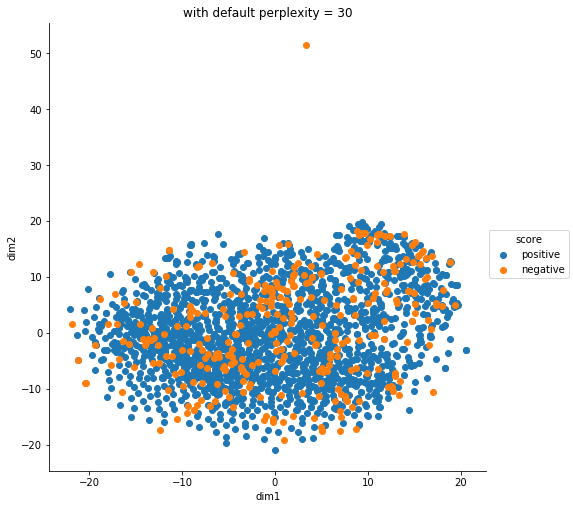

In [36]:
tsne_c= np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=7).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with default perplexity = 30")

Text(0.5,1,'with default perplexity = 50')

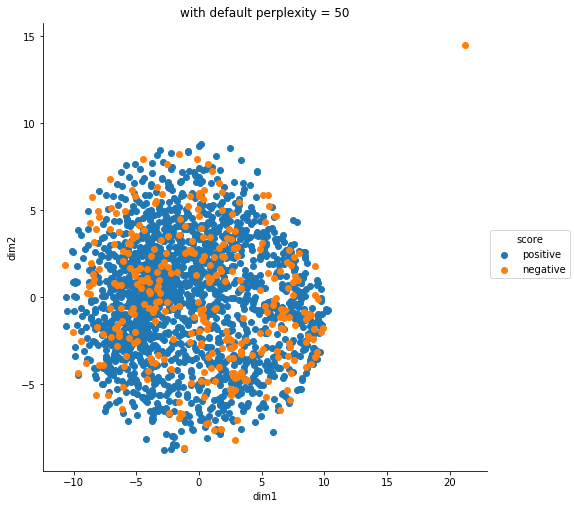

In [37]:
model=TSNE(n_components=2,random_state=0, perplexity=50)
tsne=model.fit_transform(final_counts_d)
tsne_c= np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=7).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with default perplexity = 50")

Text(0.5,1,'with default perplexity = 30 iter = 5000')

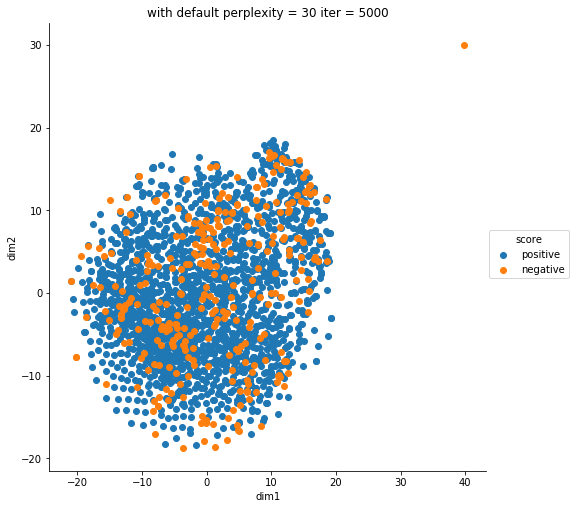

In [38]:
model=TSNE(n_components=2,random_state=0, n_iter=5000)
tsne=model.fit_transform(final_counts_d)
tsne_c= np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=7).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with default perplexity = 30 iter = 5000")

Text(0.5,1,'with default perplexity = 50 iter = 5000')

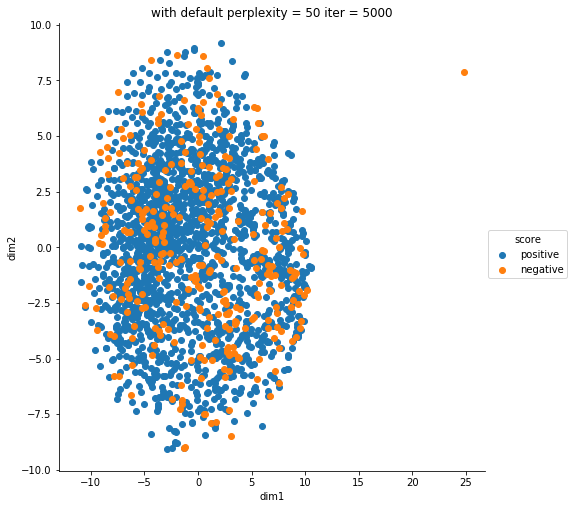

In [39]:
model=TSNE(n_components=2,random_state=0, perplexity=50, n_iter=5000)
tsne=model.fit_transform(final_counts_d)
tsne_c= np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=7).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with default perplexity = 50 iter = 5000")

# Observation:

1)Using Bow with different perplexity and steps values it can be seen that the +ve and -ve points are not easily seperrable using bow featurization or vectorization

# Tf - Idf

In [40]:
tfidf_vec=TfidfVectorizer()
final_tfidf=tfidf_vec.fit_transform(final["Text"].values)

In [41]:
final_tfidf.get_shape()

(2094, 9820)

In [42]:
final_tfidf_d=final_tfidf.todense()

In [43]:
type(final_tfidf_d)

numpy.matrixlib.defmatrix.matrix

Text(0.5,1,'with perplexity = 30')

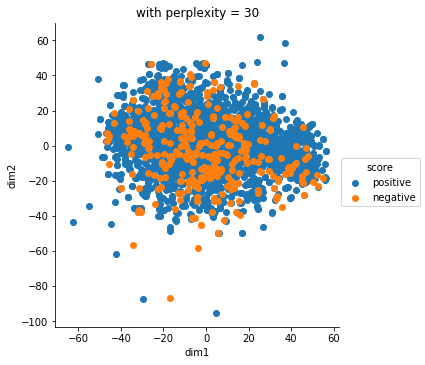

In [44]:
model=TSNE(n_components=2,random_state=0)
tsne=model.fit_transform(final_tfidf_d)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity = 30")

Text(0.5,1,'with perplexity = 50')

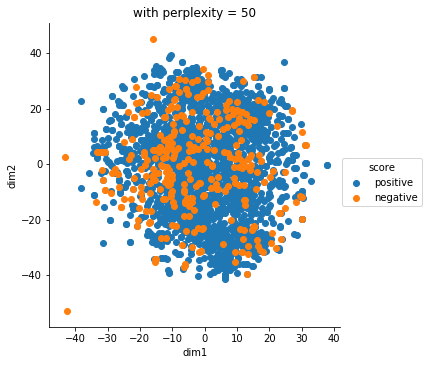

In [45]:
model=TSNE(n_components=2,random_state=0,perplexity=50)
tsne=model.fit_transform(final_tfidf_d)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity = 50")

Text(0.5,1,'with perplexity = 30, iter = 5000')

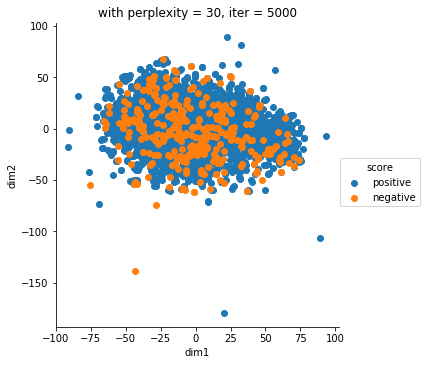

In [46]:
model=TSNE(n_components=2,random_state=0,n_iter=5000)
tsne=model.fit_transform(final_tfidf_d)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity = 30, iter = 5000")

Text(0.5,1,'with perplexity = 50, iter = 5000')

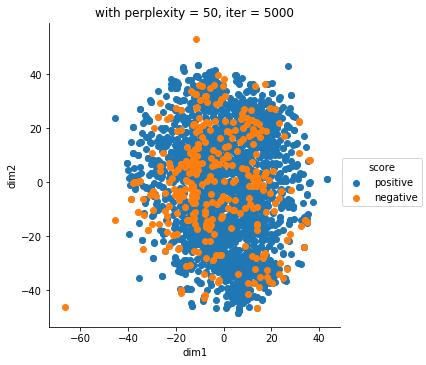

In [47]:
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne=model.fit_transform(final_tfidf_d)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity = 50, iter = 5000")

# Observation :

1)Tfidf seems to provide better results a compared to bows with perplexity 50 it can be seen that most of the -ve points belong to one of various -ve points clusters 

# Avg - W2V

In [48]:
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

C:\Users\rahul\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [49]:
print(final['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

dudes, you can't argue that there's some iconic sh** in this flick.  the characters are all killer, winona rocks in her day, and the b-juice is one of the ultiimate onscreen personas of all time.  wicked.  funny.  the scenes in the death waiting room are a scream.  for an old flick, this is good eatin.  i'm out.  j.
*****************************************************************
['dudes', 'you', 'cant', 'argue', 'that', 'theres', 'some', 'iconic', 'in', 'this', 'flick', 'the', 'characters', 'are', 'all', 'killer', 'winona', 'rocks', 'in', 'her', 'day', 'and', 'the', 'is', 'one', 'of', 'the', 'ultiimate', 'onscreen', 'personas', 'of', 'all', 'time', 'wicked', 'funny', 'the', 'scenes', 'in', 'the', 'death', 'waiting', 'room', 'are', 'a', 'scream', 'for', 'an', 'old', 'flick', 'this', 'is', 'good', 'eatin', 'im', 'out', 'j']


In [50]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=2)    


In [51]:
words = list(w2v_model.wv.vocab)
print(len(words))

2598


In [63]:
sent_vectors = []; 
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    cnt_words =0; 
    for word in sent: 
        
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

2094
50


Text(0.5,1,'with perplexity =30')

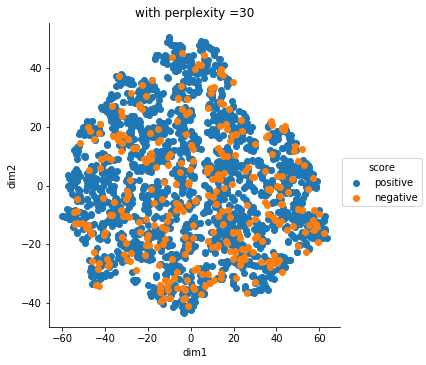

In [53]:
model=TSNE(n_components=2,random_state=0)
tsne=model.fit_transform(sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =30")

Text(0.5,1,'with perplexity =30, iter=5000')

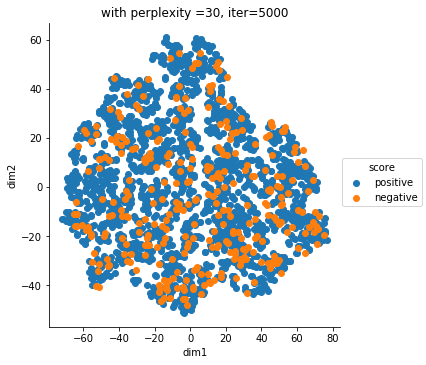

In [54]:
model=TSNE(n_components=2,random_state=0, n_iter=5000)
tsne=model.fit_transform(sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =30, iter=5000")

Text(0.5,1,'with perplexity =50')

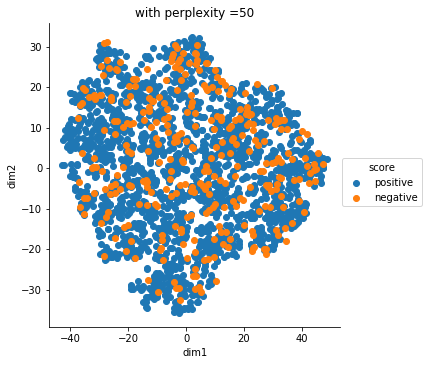

In [55]:
model=TSNE(n_components=2,random_state=0, perplexity=50)
tsne=model.fit_transform(sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =50")

Text(0.5,1,'with perplexity =50,iter = 5000')

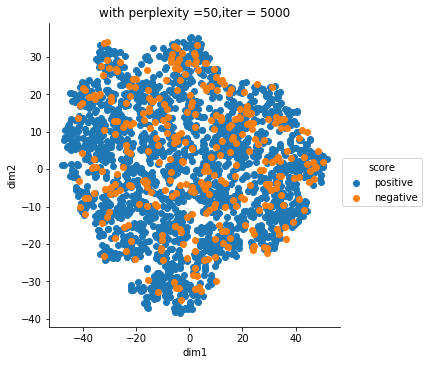

In [56]:
model=TSNE(n_components=2,random_state=0,perplexity=50,n_iter=5000)
tsne=model.fit_transform(sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =50,iter = 5000")

# Observation 

1) Avg w2v is producing very few outliers as compared to TFidf and it seems to be doing better job interms of clustering the data points , certain blue cluster have very few -ve points.
2)Hence Classification could be easier through avg-w2v featurization    

# TfIdf - W2V

In [ ]:
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec/=cnt_words
    sent_vectors.append(sent_vec)
    

In [ ]:
tfidf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    weight_sum =0;   
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf=final_tfidf[row,tfidf_feat.index(word)]
            sent_vec+=(vec*tfidf)    
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

Text(0.5,1,'with perplexity =30')

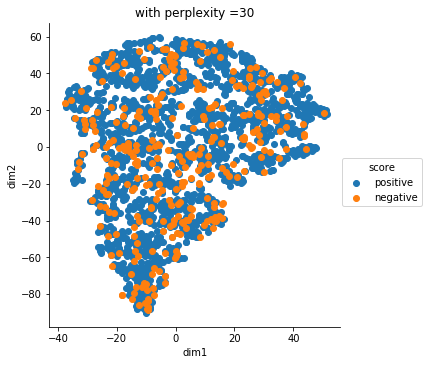

In [59]:
model=TSNE(n_components=2,random_state=0)
tsne=model.fit_transform(tfidf_sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =30")

Text(0.5,1,'with perplexity =50')

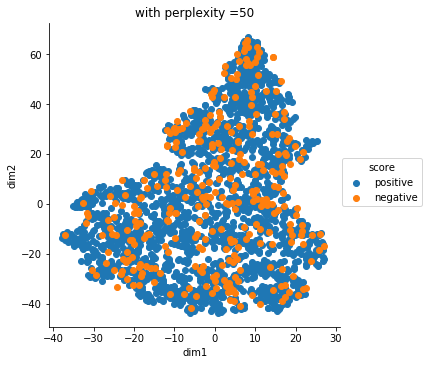

In [60]:
model=TSNE(n_components=2,random_state=0, perplexity= 50)
tsne=model.fit_transform(tfidf_sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =50")

Text(0.5,1,'with perplexity =30, iter=5000')

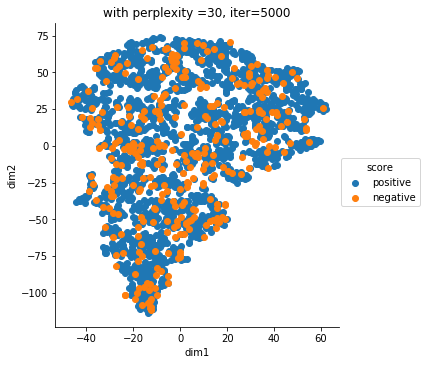

In [61]:
model=TSNE(n_components=2,random_state=0, n_iter=5000)
tsne=model.fit_transform(tfidf_sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =30, iter=5000")

Text(0.5,1,'with perplexity =50, iter=5000')

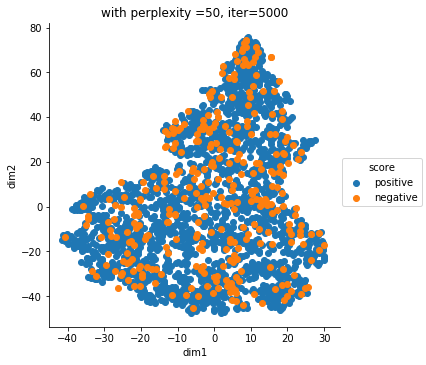

In [62]:
model=TSNE(n_components=2,random_state=0, perplexity= 50,n_iter=5000)
tsne=model.fit_transform(tfidf_sent_vectors)
tsne_c=np.vstack((tsne.T,score)).T
tsne_df=pd.DataFrame(data=tsne_c,columns=("dim1","dim2","score"))
sn.FacetGrid(tsne_df,hue="score",size=5).map(plt.scatter,"dim1","dim2").add_legend()
plt.title("with perplexity =50, iter=5000")

# Observation 

1) Similar to Avg w2v TfIdf is producing very few outliers as compared to TFidf and  seems to be doing better job interms of clustering the data points .But clustering seemes better that what avg- w2 has produced
2)  Classification could be easier through tfidf-w2v featurization as compared to all other featurizations 